# **Desafio de Redes Neurais Convolucionais - Gabriel Dantas de Moraes Almeida**

Repositório Git desse desafio: [link](https://github.com/gdantas04/Desafios-Trainee-IEEE-CIS/tree/main/semana04).

---
## Etapa 0: Preparação do ambiente

Para iniciar, vamos importar as bibliotecas necessárias para esse desafio:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import random_split
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Subset

import os

import glob

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

Agora vamos configurar o Pytorch para usar a placa de vídeo, caso ela esteja disponível.

In [1108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


O output acima indica que o dispositivo em uso é a placa de vídeo.

---

## Etapa 1: Carregamento e visualização inicial dos dados

Seguindo uma lógica análoga ao exemplo disponibilizado no GitHub do Desafio 04, podemos iniciar definindo as transformações iniciais para o conjunto de dados.

O código abaixo define a seguinte transformação: converte as imagens para tensor e as redimensiona para 128x128 pixels.

In [1109]:
initial_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((128, 128))
    ]
)

Agora podemos carregar os datasets de treino e teste e aplicar a transformação definida acima. Vamos inicialmente chamar o dataset de treino de ```base_dataset```, pois futuramente iremos dividir seus dados em treino e validação.

Cria-se um conjunto de validação para ajustar os hiperparâmetros de modo a maximizar os scores. O conjunto de teste será utilizado somente ao final da implementação do modelo, com o intuito de compreender como nossa rede neural se comporta com dados externos.

In [1110]:
base_dataset = ImageFolder("clouds/clouds_train", transform=initial_transforms)
test_dataset = ImageFolder("clouds/clouds_test", transform=initial_transforms)

Para compreender quantas são as classes de nuvens e como elas estão balanceadas, podemos implementar o gráfico abaixo:

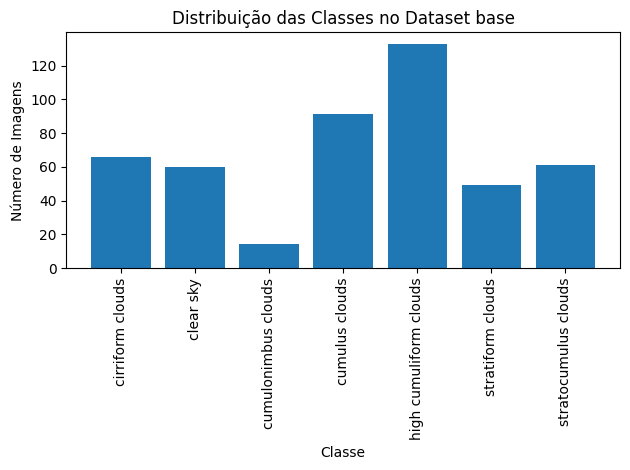

In [1111]:
# Conta os rótulos
labels_list = [sample[1] for sample in base_dataset.samples]
label_counts = Counter(labels_list)

# Mapeia as classes
class_counts = {base_dataset.classes[i]: count for i, count in label_counts.items()}

# Plot
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Distribuição das Classes no Dataset base")
plt.xlabel("Classe")
plt.ylabel("Número de Imagens")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Nitidamente há um forte desbalanceamento entre as classes. É fundamental tratarmos isso futuramente.

Uma solução que será aplicada é utilizar o ```WeightedRandomSampler``` durante o treinamento. Isso corrige o desequilíbrio dando peso maior para classes raras no carregamento dos dados.

Adicionalmente, podemos ver como estão a média e o desvio padrão das amostras. Isso nos indica se será necessário normalizar os dados.  

In [1112]:
means = []
stds = []

for img, _ in base_dataset:
    means.append(torch.mean(img))
    stds.append(torch.std(img))

print(f"Média dos valores de pixel: {np.mean(means):.2f}")
print(f"Desvio padrão: {np.mean(stds):.2f}")

Média dos valores de pixel: 0.56
Desvio padrão: 0.12


Normalizar os dados usando a média 0.56 e desvio 0.12 centraliza os valores dos pixels em torno de zero, o que ajuda a estabilizar e acelerar o treinamento do modelo.

---
## Etapa 2: Data Augmentation e Transformações

Com o intuito de auxiliar o modelo a generalizar o aprendizado e simular uma maior diversidade no dataset, é muito importante dar olhos ao processo de transformação das variáveis.

De maneira geral, as transformações são operações aplicadas à imagem antes de fornecer os dados à rede neural.

Em casos de pré-processamento, elas garantem que os dados tenham o formato e a escala esperados pela rede.

Um subtipo muito importante de transformação é o **Data Augmentation**, o qual se baseia em aplicar variações aleatórias (controladas) às imagens para aumentar artificialmente a diversidade do dataset.

Na maioria das vezes, o Data Augmentation:
- Reduz o overfitting
- Simula o mundo real
- Compensa datasets pequenos
- Ajuda o modelo a generalizar


Além disso, é importante notar que o Data Augmentation deve ser implementado somente nos dados de treinamento. Para os dados de teste, não é necessário aplicar esse tipo de transformação.

Podemos definir as seguintes transformações e data augmentations:

In [1113]:
Transformations = transforms.Compose([
    transforms.Resize((128, 128)),                  # Redimensiona para imagem PIL
    transforms.ToTensor(),                          # Converte para tensor 
    transforms.Normalize(mean=[0.56, 0.56, 0.56],
                         std=[0.12, 0.12, 0.12])    # Normalização dos dados
])

Transformations_aug = transforms.Compose([
    transforms.Resize((128, 128)),                          # Redimensiona para imagem PIL
    transforms.RandomHorizontalFlip(),                      # Data augmentation
    transforms.RandomRotation(10),                          # Data augmentation
    transforms.ToTensor(),                                  # Converte para tensor 
    transforms.Normalize(mean=[0.56, 0.56, 0.56],
                         std=[0.12, 0.12, 0.12])            # Normalização dos dados
])


Conforme comentado, não iremos fazer data augmentation no conjunto de teste, apenas transformar os dados para ficarem compatíveis com o conjunto de treino.

Conforme comentado, vamos dividir a pasta "clouds/clouds_test" em treino e validação.

Para isso, escolhemos utilizar 20% dos dados do ```base_dataset``` para validação, o restante será utilizado para treino.

Vamos ter 2 datasets de treino, um com data Data Augmentation e o outro sem.

In [1114]:
# Parâmetros para o split
val_ratio = 0.2
total_size = len(base_dataset)
val_size = int(val_ratio * total_size)
train_size = total_size - val_size

# Gerador com seed fixa
generator = torch.Generator().manual_seed(42)

# Fazer divisão em treino e validação
train_dataset, val_dataset = random_split(base_dataset, [train_size, val_size], generator=generator)

# Criar uma "cópia" do train_dataset
train_dataset_aug = Subset(base_dataset, train_dataset.indices)

Agora resta aplicar as transformações em cada conjunto:

In [1115]:
train_dataset.transform = Transformations
train_dataset_aug.transform = Transformations_aug

val_dataset.dataset.transform = Transformations

test_dataset.transform = Transformations

---
## Etapa 3: Divisão do Dataset

Como comentado anteriormente, o conjunto de dados é desbalanceado. Por isso, é fundamental treinar o modelo com base em uma ponderação sobre as classes. Isso permite que o modelo generalize melhor por meio do balanceamento da "atenção" que ele emprega em cada classe.

Dessa maneira, o código abaixo permite que o modelo veja todas as classes com uma frequência semelhante, mesmo que o dataset original seja desbalanceado.

In [1116]:
# Pega as labels do conjunto de treino
train_labels = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]

# Conta quantas amostras tem por classe
class_counts = Counter(train_labels)

# Calcula o peso pelo inverso da frequência da classe
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Peso de cada amostra
sample_weights = [class_weights[label] for label in train_labels]
sample_weights_tensor = torch.DoubleTensor(sample_weights)

# Usa WeightedRandomSampler para que o dataLoader sorteie as amostras de forma balanceada
sampler = WeightedRandomSampler(weights=sample_weights_tensor,
                                num_samples=len(sample_weights_tensor),
                                replacement=True)

Agora basta criar o dataloader para o conjunto de treino e teste, aplicando o sampler implementado no bloco anterior.

Além disso, é fundamental definir o número de batches do modelo, ou seja, quantas imagens são processadas ao mesmo tempo pela rede neural durante o treinamento. 

Escolheu-se 32 imagens por ser um número conhecido pelo equilíbrio entre tempo e desempenho nesse tipo de rede neural.

In [1117]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, sampler=sampler)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

---
## Etapa 4: Definição da CNN

Agora que os dados foram divididos em treinamento e teste, devemos implementar a Rede Neural Convolucional.

O funcionamento básico geral de uma classe de CNN no PyTorch é a seguinte:

1) A classe herda ```nn.module```. Isso torna a rede compatível com o PyTorch.
2) Definimos os componentes da arquitetura e as camadas no `__init__`. O código a seguir contém as seguintes componentes:
    - ```Conv2d```: detecta padrões locais como bordas e texturas
    - ```BatchNorm2d```: normaliza a saída para tornar o treinamento mais estável
    - ```MaxPool2d```: reduz a resolução da imagem
    - ```AdaptiveAvgPool2d```: reduz a resolução da imagem para um tamanho fixo
    - ```Dropout```: regularização para evitar overfitting
    - ```Linear```: decisores que escolhem a categoria com base no que foi visto.
3) Agora definimos a função ```forward```, que define a ordem do fluxo de dados.


Como função de ativação, utilizou-se o **elu**, como uma sugestão apresentada no GitHub do Módulo 04.

In [1118]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Camadas convolucionais
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling e Adaptive Pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Camadas totalmente conectadas
        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.elu(self.bn1(self.conv1(x))))
        x = self.pool(F.elu(self.bn2(self.conv2(x))))
        x = self.pool(F.elu(self.bn3(self.conv3(x))))
        x = self.pool(F.elu(self.bn4(self.conv4(x))))

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        x = self.dropout(F.elu(self.fc1(x)))
        x = self.fc2(x)
        return x

---
## Etapa 5: Configuração de Treinamento com Regularização e Otimizador

Antes de configurar o treinamento, vamos instanciar o modelo de CNN criado no tópico anterior e movê-lo para a placa de vídeo.

In [1119]:
num_classes = len(base_dataset.classes)

model = CNN(num_classes=num_classes).to(device)
model_aug = CNN(num_classes=num_classes).to(device)

Como comentado anteriormente, existe uma preocupação com relação ao desbalanceamento dos dados.

Dessa forma, também é fundamental definir a função de perda com base nos pesos de cada classe. Assim, analogamente ao que foi apresentado, podemos calcular tais pesos da seguinte maneira:

In [1120]:
# Conta as classes no dataset de treino
label_counts = Counter(train_labels)
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Calcula os pesos
class_weights = [total_samples / label_counts[i] for i in range(num_classes)]

# Move para o dispositivo antes de definir o loss
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

Agora que temos um tensor com os pesos de cada classe, podemos passar o ```class_weights_tensor``` como parâmetro da função de perda ```CrossEntropyLoss```, a qual foi escolhida como uma sugestão do material de apoio do Módulo 04 para esse tipo de problema.

In [1121]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

Podemos visualizar os pesos que estão sendo aplicados:

In [1122]:
class_names = train_dataset.dataset.classes 

for i, weight in enumerate(class_weights):
    class_name = class_names[i]
    print(f"{class_name:23s} -> peso: {weight:.2f}")

cirriform clouds        -> peso: 8.09
clear sky               -> peso: 7.60
cumulonimbus clouds     -> peso: 38.00
cumulus clouds          -> peso: 5.14
high cumuliform clouds  -> peso: 3.58
stratiform clouds       -> peso: 9.74
stratocumulus clouds    -> peso: 7.04


Adicionalmente, podemos definir o otimizador Adam com regularização L2.

Isso será feito e aplicado na Etapa 6, onde implementaremos uma função de treinamento da CNN.

Faz-se isso na Etapa 6 pois o otimizador depende do learning rate, o qual será passado como parâmetro para a função de treinamento.

---
## Etapa 6: Treinamento da CNN do Zero

### Definindo a função de treinamento

Com o intuito de facilitar a obtenção dos melhores parâmetros, iremos implementar uma função de treinamento/validação que recebe como entrada:

1. Número de épocas  

2. Learning rate  

3. Fator de regularização L2

4. O modelo a ser treinado

5. Ativação ou não de regularização e augmentation


Isso é extremamente útil pois iremos variar esses parâmetros com o intuito de maximizar o F1-Score do conjunto de validação.


Além disso, nossa função irá armazenar as acurácias e os losses em arrays, os quais serão úteis para uma visualização futura com MatPlotLib.

É importante comentar que os melhores parâmetros (definidos como default na função) foram obtidos testando diferentes combinações de entrada e analisando qual fornecia as melhores métricas. 

In [ ]:
def train_val(epochs=40, lr=0.0001, l2=1e-4, model=model_aug, aug_and_reg=True):
    
    # Otimizador com regularização L2 opcional
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2 if aug_and_reg else 0)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Seleciona o dataloader com ou sem data augmentation
    loader = train_loader_aug if aug_and_reg else train_loader

    for epoch in range(epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = running_loss / len(loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validação
        model.eval()
        running_val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Exibe progresso a cada 10 épocas ou na primeira
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch: {epoch+1:>3}/{epochs:<3} | "
                  f"Train Loss: {train_loss:>8.4f} | "
                  f"Val Loss: {val_loss:>8.4f} | "
                  f"Train Acc: {train_acc:>7.4f} | "
                  f"Val Acc: {val_acc:>7.4f}")
    
    return train_losses, val_losses, train_accs, val_accs, all_val_preds, all_val_labels, epochs

### Treinando os modelos

Para treinar e validar o modelo **sem augmentation**, basta chamar a função da seguinte maneira:

In [1124]:
(train_losses,
 val_losses,
 train_accs,
 val_accs,
 all_val_preds,
 all_val_labels,
 epochs) = train_val(model=model, aug_and_reg=False)

Epoch:   1/40  | Train Loss:   1.0299 | Val Loss:   1.6138 | Train Acc:  0.4184 | Val Acc:  0.2872
Epoch:  10/40  | Train Loss:   0.2054 | Val Loss:   0.8611 | Train Acc:  0.8711 | Val Acc:  0.7234
Epoch:  20/40  | Train Loss:   0.0887 | Val Loss:   0.7165 | Train Acc:  0.9421 | Val Acc:  0.7872
Epoch:  30/40  | Train Loss:   0.0760 | Val Loss:   0.8140 | Train Acc:  0.9553 | Val Acc:  0.8298
Epoch:  40/40  | Train Loss:   0.0456 | Val Loss:   0.7058 | Train Acc:  0.9711 | Val Acc:  0.8511


Agora, **com augmentation**:

In [1125]:
(train_losses_aug,
 val_losses_aug,
 train_accs_aug,
 val_accs_aug,
 all_val_preds_aug,
 all_val_labels_aug,
 epochs_aug) = train_val(model=model_aug, aug_and_reg=True)

Epoch:   1/40  | Train Loss:   0.8780 | Val Loss:   1.6152 | Train Acc:  0.5158 | Val Acc:  0.2872
Epoch:  10/40  | Train Loss:   0.2295 | Val Loss:   0.7420 | Train Acc:  0.8684 | Val Acc:  0.7234
Epoch:  20/40  | Train Loss:   0.0833 | Val Loss:   0.5486 | Train Acc:  0.9447 | Val Acc:  0.8404
Epoch:  30/40  | Train Loss:   0.0514 | Val Loss:   0.7288 | Train Acc:  0.9842 | Val Acc:  0.8085
Epoch:  40/40  | Train Loss:   0.0373 | Val Loss:   0.6886 | Train Acc:  0.9711 | Val Acc:  0.8617


### Analisando os resultados no conjunto de validação

Para analisar as métricas por categoria e visualizar a evolução do modelo, podemos implementar o código abaixo.

In [1126]:
def GetValResults(train_losses, val_losses, train_accs, val_accs, all_val_preds, all_val_labels, epochs):
    # Relatório Final de validação
    print("Classification Report (Validação):\n")
    print(classification_report(all_val_labels, all_val_preds, target_names=train_dataset.dataset.classes))

    # Plot das curvas
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Curva de Perda')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, val_accs, label='Val Acc')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Curva de Acurácia')
    plt.legend()

    plt.tight_layout()
    plt.show()

Os resultados **sem augmentation** são os seguintes:

Classification Report (Validação):

                        precision    recall  f1-score   support

      cirriform clouds       0.86      0.95      0.90        19
             clear sky       1.00      1.00      1.00        10
   cumulonimbus clouds       1.00      0.50      0.67         4
        cumulus clouds       0.76      0.76      0.76        17
high cumuliform clouds       1.00      0.78      0.88        27
     stratiform clouds       0.91      1.00      0.95        10
  stratocumulus clouds       0.50      0.86      0.63         7

              accuracy                           0.85        94
             macro avg       0.86      0.84      0.83        94
          weighted avg       0.88      0.85      0.85        94



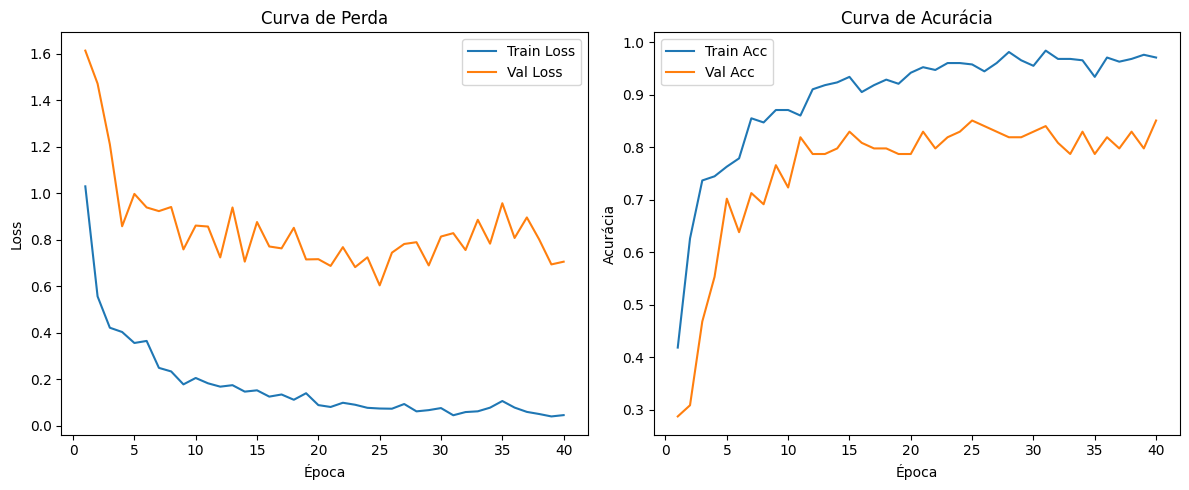

In [1127]:
GetValResults(train_losses,
              val_losses,
              train_accs,
              val_accs,
              all_val_preds,
              all_val_labels,
              epochs)

**Com augmentation** são esses:

Classification Report (Validação):

                        precision    recall  f1-score   support

      cirriform clouds       0.89      0.84      0.86        19
             clear sky       1.00      1.00      1.00        10
   cumulonimbus clouds       1.00      0.50      0.67         4
        cumulus clouds       0.82      0.82      0.82        17
high cumuliform clouds       0.92      0.85      0.88        27
     stratiform clouds       0.77      1.00      0.87        10
  stratocumulus clouds       0.67      0.86      0.75         7

              accuracy                           0.86        94
             macro avg       0.87      0.84      0.84        94
          weighted avg       0.87      0.86      0.86        94



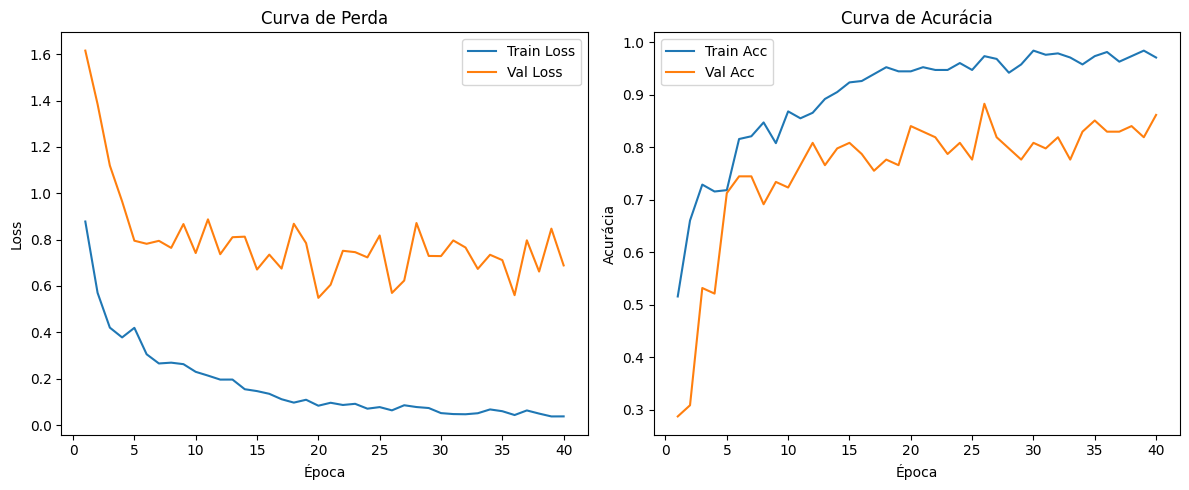

In [1128]:
GetValResults(train_losses_aug,
              val_losses_aug,
              train_accs_aug,
              val_accs_aug,
              all_val_preds_aug,
              all_val_labels_aug,
              epochs_aug)

Com base na análise, observou-se que:
- Houve uma leve melhoria em praticamente todas as métricas;

- Os gráficos de Loss x Época e Acurácia x Época foram semelhantes nos dois casos, mas com uma melhoria sutil após as alterações;

- O ```val_loss``` final foi menor, indicando que o modelo passou a gerar previsões mais próximas dos valores reais.

Esse resultado era esperado e confirma que as modificações tiveram efeito positivo.

Ainda assim, **há espaço para melhorias adicionais**, e acredita-se que novas alterações possam elevar ainda mais o desempenho do modelo.

### Expondo o modelo ao conjunto de teste

Após treinar o modelo e estudar sua evolução no conjunto de validação, resta expor nosso modelo ao conjunto de teste e ver como ele se comporta.

Essa etapa nos indicará o quão bem a rede neural generalizou e qual será o comportamento dela ao receber dados de fora do dataset de treino.

Para isso, implementou-se a função abaixo.

In [1129]:
def ModelTest(model=model, df_train=train_dataset):
    model.eval()

    all_preds = []
    all_labels = []

    running_test_loss = 0.0

    # Com o no_grad, não calculamos gradientes (economiza memória)
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Armazena as previsões e os rótulos para avaliação
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcula o test loss médio e imprime
    test_loss = running_test_loss / len(test_loader)
    print(f"-> Test Loss: {test_loss:.4f}\n")

    report = classification_report(all_labels,
                                   all_preds,
                                   target_names=df_train.dataset.classes)

    print(report)

    return all_preds, all_labels

In [1130]:
all_preds, all_labels = ModelTest()

-> Test Loss: 0.5309

                        precision    recall  f1-score   support

      cirriform clouds       0.74      0.78      0.76        77
             clear sky       0.89      0.98      0.93        64
   cumulonimbus clouds       0.78      0.64      0.70        11
        cumulus clouds       0.93      0.78      0.85       120
high cumuliform clouds       0.83      0.78      0.80       103
     stratiform clouds       0.87      0.97      0.92        40
  stratocumulus clouds       0.70      0.82      0.75        71

              accuracy                           0.83       486
             macro avg       0.82      0.82      0.82       486
          weighted avg       0.83      0.83      0.83       486



Conforme visto, acredita-se ter obtido F1-Scores desejáveis, com um **macro avg de 82% aproximadamente** e um **loss de 0.5309**.

Acredita-se que para um dataset pequeno e desbalanceado, o resultado é satisfatório.

Conforme observado nos gráficos, 40 épocas representaram um bom ponto de equilíbrio, marcando o limiar entre o melhor desempenho e o início de overfitting.

Com isso, podemos gerar nossa submissão do desafio conforme o código abaixo, o qual foi retirado do GitHub do Módulo 04.

In [ ]:
submission_filenames = [os.path.basename(path) for path, _ in test_dataset.samples]

all_preds_np = np.array(all_preds)

predicted_class_names = [test_dataset.classes[i] for i in all_preds_np]


# Cria um DataFrame do Pandas para a submissão
my_submission_df = pd.DataFrame({
    'row_id': submission_filenames, # Os nomes dos arquivos como IDs
    'label': predicted_class_names  # Os rótulos previstos pelo modelo
})

# Salva o DataFrame em um arquivo CSV
my_submission_df.to_csv('my_submission.csv', index=False)
print("\nArquivo my_submission.csv (submissão do modelo) gerado com sucesso!")
my_submission_df.head()


Arquivo my_submission.csv (submissão do modelo) gerado com sucesso!


,row_id,label
0,0208a6357f23cf53980f72dea42ade63.jpg,cirriform clouds
1,03775c45f7cc00d8aa7eccdb482b76af.jpg,cirriform clouds
2,04649cdcf0f8bc537233cdb724fee004.jpg,cirriform clouds
3,05817a2a04bb3c19684e39adbd0c6583.jpg,high cumuliform clouds
4,11595750ac2dd8fbce2f67ea40d21acd.jpg,cirriform clouds


Com o objetivo de garantir a verificação da acurácia do nosso modelo, iremos gerar o arquivo de gabarito e comparar os resultados. Emitiremos o gabarito conforme o código abaixo (também retirado do GitHub do Módulo 4).

In [1132]:
test_root_dir = "clouds/clouds_test"

image_paths_solution = sorted(glob.glob(os.path.join(test_root_dir, "*", "*.jpg")))

np.random.seed(42)
shuffled_paths = np.random.permutation(image_paths_solution)

solution_data = []

# Processa os caminhos para o conjunto Público
for path in shuffled_paths:
    filename = os.path.basename(path) # Extrai o nome do arquivo do caminho
    label = os.path.basename(os.path.dirname(path)) # Extrai o nome da classe (nome da subpasta)
    solution_data.append({
        'row_id': filename, # O nome do arquivo é o ID da linha
        'label': label      # O rótulo verdadeiro da imagem
    })

# Cria um DataFrame do Pandas com os dados coletados
solution_df = pd.DataFrame(solution_data)

# Salva o DataFrame em um arquivo CSV
solution_df.to_csv('solution.csv', index=False)
print("\nArquivo solution.csv (gabarito para competição) gerado com sucesso!")
solution_df.head()


Arquivo solution.csv (gabarito para competição) gerado com sucesso!


,row_id,label
0,294bc8905511189f805042a516730723.jpg,stratocumulus clouds
1,f140e8b248e27bb2ca10ffde09ef6013.jpg,cumulus clouds
2,72619270d74d7120e8f8447d2d458a1b.jpg,stratocumulus clouds
3,a6d1c3b86279c54afd4e2fdf0b88111a.jpg,stratocumulus clouds
4,f18d631f6a37d3e2a8e0d91bea426dfb.jpg,high cumuliform clouds


Agora podemos juntar os dois datasets em apenas um, para facilitar a comparação.

In [1133]:
comparacao = solution_df.merge(my_submission_df, on='row_id', suffixes=('_true', '_pred'))
comparacao.head()

,row_id,label_true,label_pred
0,294bc8905511189f805042a516730723.jpg,stratocumulus clouds,stratocumulus clouds
1,f140e8b248e27bb2ca10ffde09ef6013.jpg,cumulus clouds,cumulus clouds
2,72619270d74d7120e8f8447d2d458a1b.jpg,stratocumulus clouds,stratocumulus clouds
3,a6d1c3b86279c54afd4e2fdf0b88111a.jpg,stratocumulus clouds,stratocumulus clouds
4,f18d631f6a37d3e2a8e0d91bea426dfb.jpg,high cumuliform clouds,high cumuliform clouds


Agora basta contar quantos dados nosso modelo previu corretamente.

In [1134]:
acertos = (comparacao['label_true'] == comparacao['label_pred']).sum()
total = len(comparacao)
acuracia = (acertos / total)*100

print(f"Acertos: {acertos}/{total}")
print(f"Acurácia: {acuracia:.2f}%")

Acertos: 401/486
Acurácia: 82.51%


A acurácia obtida é exatamente a mesma mostrada no ```ClassificationReport```, o que indica que nossa submissão foi gerada corretamente.

---
## Etapa 7: Transfer Learning com Modelo Pré-Treinado

Nosso objetivo agora é aplicar o **Transfer learning**.

Esta é uma técnica em que um modelo treinado em uma grande base de dados (como o ImageNet) é reutilizado para resolver outra tarefa relacionada, economizando tempo e recursos.

Em vez de treinar tudo do zero, apenas ajustamos partes do modelo para a nova tarefa.

Isso é especialmente útil quando temos poucos dados disponíveis para o novo problema.

Com isso, podemos iniciar carregando o modelo com os pesos pré-treinados do ImageNet.

O modelo que estaremos utilizando é o ```resnet18```, o qual é conhecido pelo bom equilíbrio entre desempenho e custo computacional.

In [1135]:
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)

Para adequar o modelo ao número de classes, devemos substituir a última camada totalmente conectada:

In [1136]:
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

Também podemos mover o modelo para a placa de vídeo, de modo a acelerar o treinamento.

In [1137]:
resnet = resnet.to(device)

Agora, vamos congelar todos os parâmetros do modelo. Fazemos isso para aplicar o transfer learning de forma eficiente.

As camadas anteriores já aprenderam boas representações genéricas de imagens a partir do ImageNet.

Isso nos possibilita reduzir o tempo de treinamento e evita overfitting.

Apenas a última camada (fc) é treinada para ajustar o modelo à nova tarefa (no caso a classificação de tipos de nuvens).

In [1138]:
# Congela os parâmetros do modelo
for param in resnet.parameters():
    param.requires_grad = False

# Apenas a última camada se mantém treinável
for param in resnet.fc.parameters():
    param.requires_grad = True

Agora basta aplicar a função de treinamento e validação implementada anteriormente.

De antemão, sugeriu-se que o novo modelo é **mais resistente à overfitting**, o que nos possibilita aumentar consideravelmente o número de épocas.

Para provar isso, definiu-se 300 épocas e ainda assim notou-se uma convergência crescente das métricas.

In [ ]:
(train_losses_res,
 val_losses_res,
 train_accs_res,
 val_accs_res,
 all_val_preds_res,
 all_val_labels_res,
 epochs_res) = train_val(epochs=300,
                        lr=0.0001,
                        l2=1e-3,
                        model=resnet)

Epoch:   1/300 | Train Loss:   1.9089 | Val Loss:   2.1227 | Train Acc:  0.1605 | Val Acc:  0.1170
Epoch:  10/300 | Train Loss:   1.0869 | Val Loss:   1.6107 | Train Acc:  0.3868 | Val Acc:  0.2340
Epoch:  20/300 | Train Loss:   0.8493 | Val Loss:   1.2406 | Train Acc:  0.5789 | Val Acc:  0.5000
Epoch:  30/300 | Train Loss:   0.5815 | Val Loss:   0.9929 | Train Acc:  0.7289 | Val Acc:  0.5532
Epoch:  40/300 | Train Loss:   0.5163 | Val Loss:   0.8308 | Train Acc:  0.8079 | Val Acc:  0.7234
Epoch:  50/300 | Train Loss:   0.3703 | Val Loss:   0.7013 | Train Acc:  0.8737 | Val Acc:  0.8085
Epoch:  60/300 | Train Loss:   0.3354 | Val Loss:   0.6764 | Train Acc:  0.9158 | Val Acc:  0.8298
Epoch:  70/300 | Train Loss:   0.2985 | Val Loss:   0.5915 | Train Acc:  0.8974 | Val Acc:  0.8723
Epoch:  80/300 | Train Loss:   0.2664 | Val Loss:   0.6099 | Train Acc:  0.9105 | Val Acc:  0.8617
Epoch:  90/300 | Train Loss:   0.2277 | Val Loss:   0.5708 | Train Acc:  0.9395 | Val Acc:  0.8830
Epoch: 100

Podemos avaliar os resultados da validação:

Classification Report (Validação):

                        precision    recall  f1-score   support

      cirriform clouds       0.89      0.89      0.89        19
             clear sky       1.00      1.00      1.00        10
   cumulonimbus clouds       1.00      0.50      0.67         4
        cumulus clouds       0.94      1.00      0.97        17
high cumuliform clouds       0.92      0.89      0.91        27
     stratiform clouds       0.75      0.90      0.82        10
  stratocumulus clouds       0.71      0.71      0.71         7

              accuracy                           0.89        94
             macro avg       0.89      0.84      0.85        94
          weighted avg       0.90      0.89      0.89        94



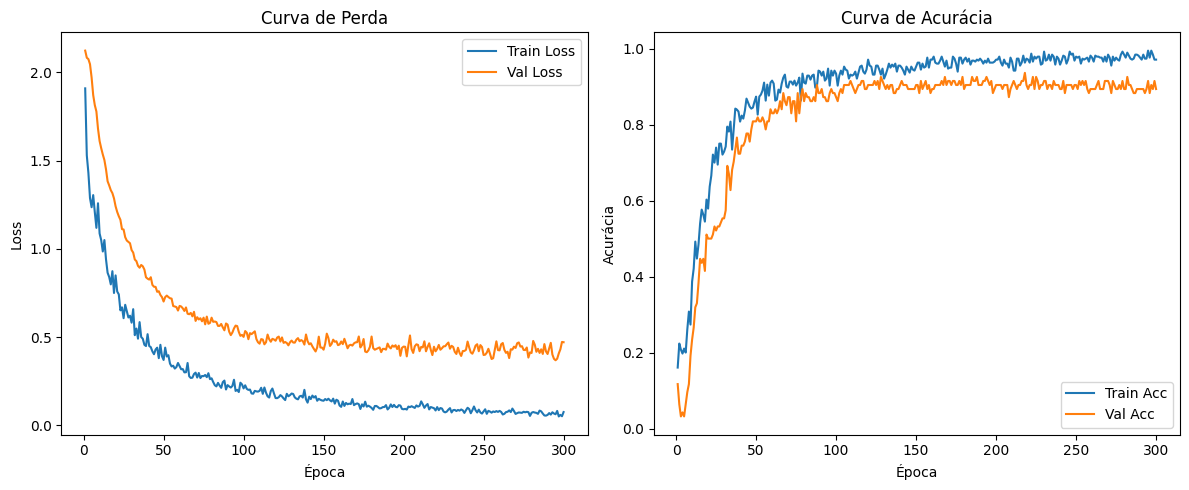

In [1140]:
GetValResults(train_losses_res,
              val_losses_res,
              train_accs_res,
              val_accs_res,
              all_val_preds_res,
              all_val_labels_res,
              epochs_res)

Nitidamente obtivemos um **aumento considerável em todas as métricas**, o que era esperado ao se utilizar um modelo pré treinado.

Pelos gráficos acima, nota-se que **as curvas de Train Loss e Val Loss são próximas e consistentes**, o que nos indica uma **baixa presença de overfitting**.

Tendo os resultados como satisfatórios, podemos expor o modelo ao dataset de teste.

In [1141]:
all_preds_res, all_labels_res = ModelTest(resnet)

-> Test Loss: 0.3710

                        precision    recall  f1-score   support

      cirriform clouds       0.89      0.95      0.92        77
             clear sky       0.98      0.98      0.98        64
   cumulonimbus clouds       0.50      0.55      0.52        11
        cumulus clouds       0.91      0.88      0.90       120
high cumuliform clouds       0.89      0.79      0.84       103
     stratiform clouds       0.83      0.88      0.85        40
  stratocumulus clouds       0.72      0.80      0.76        71

              accuracy                           0.87       486
             macro avg       0.82      0.83      0.82       486
          weighted avg       0.87      0.87      0.87       486



Com base nisso, nota-se que:
- O modelo de transfer learning obteve **scores superiores** aos apresentados pelo modelo treinado do zero
- Com o transfer learning, houve uma **redução de 0,16 no loss do teste**
- O modelo de transfer learning é **mais resistente a overfitting**, o que foi observado visualmente pelos gráficos
- Houve uma **redução nos scores da classe "cumulonimbus clouds"**, embora a **acurácia obtida tenha aumentado em 4%**

---
## Conclusões

Com o objetivo de fazer uma análise final, vamos implementar um mapa de confusão normalizado, conforme abaixo:

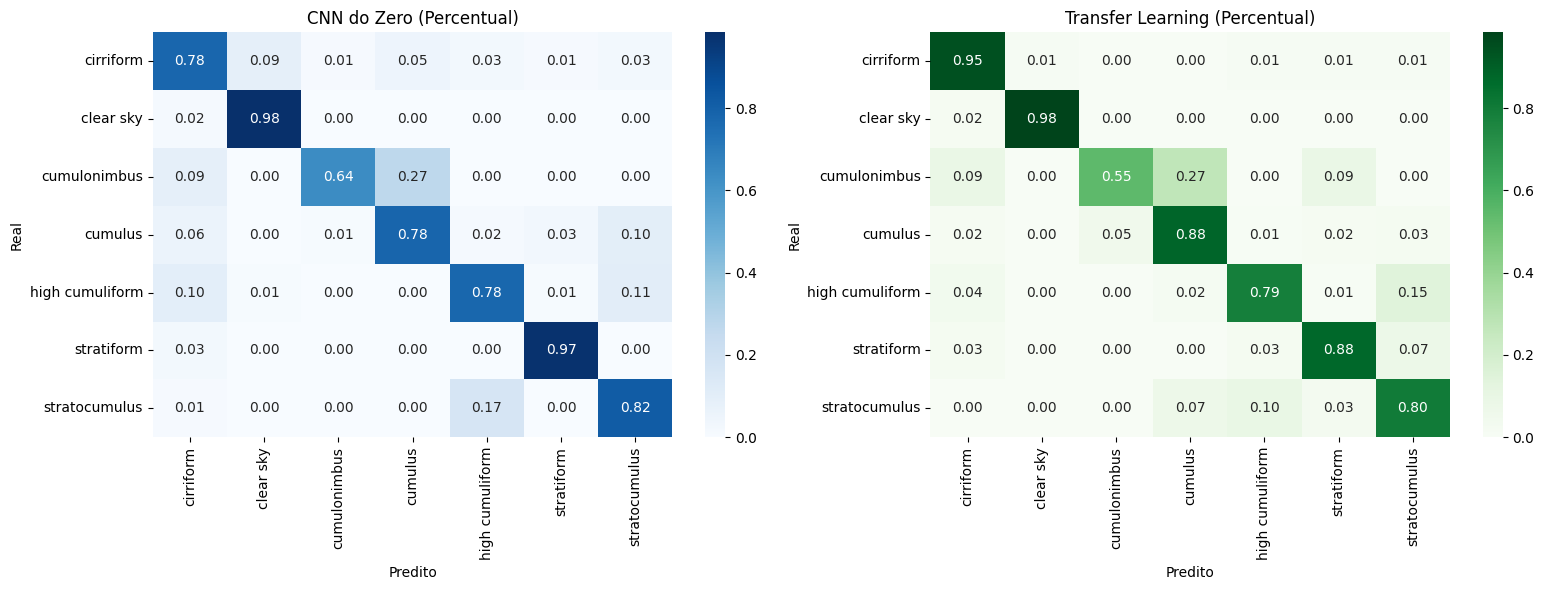

In [ ]:
labels = ["cirriform", "clear sky", "cumulonimbus", "cumulus", "high cumuliform", "stratiform", "stratocumulus"]

# Matrizes de confusão
cm_cnn = confusion_matrix(all_labels, all_preds)
cm_resnet = confusion_matrix(all_labels_res, all_preds_res)

# Normaliza por linha (por classe real)
cm_cnn_pct = cm_cnn.astype('float') / cm_cnn.sum(axis=1)[:, np.newaxis]
cm_resnet_pct = cm_resnet.astype('float') / cm_resnet.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_cnn_pct, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("CNN do Zero (Percentual)")
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")

sns.heatmap(cm_resnet_pct, annot=True, fmt=".2f", cmap="Greens", xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Transfer Learning (Percentual)")
axes[1].set_xlabel("Predito")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()

O uso de Transfer Learning trouxe alguns ganhos evidentes nos recalls, principalmente nas classes "cirriform" e "cumulus", que apresentaram métricas mais consistentes.

Além disso, houve uma redução nos erros de confusão entre algumas classes, como "cumulonimbus" e "stratiform". Embora a CNN do zero tenha apresentado bons resultados em algumas categorias, como clear sky e stratiform, o modelo com Transfer Learning demonstrou ser mais robusto de forma geral.

---

Dado o exposto, neste desafio foi desenvolvido um modelo de classificação de imagens de nuvens utilizando CNNs, com foco em estudar o impacto de técnicas de Data Augmentation e regularização (L2). Os resultados obtidos mostraram que:

* O uso de **Data Augmentation** e **regularização** proporcionou melhorias modestas, nas métricas de desempenho, ajudando o modelo a generalizar melhor.
* O gráfico de loss e acurácia ao longo das épocas indicou que cerca de **40 épocas** representaram o ponto de maior desempenho antes do início de overfitting.
* A aplicação de uma rede pré-treinada, no caso a **ResNet18**, se mostrou promissora e talvez represente um próximo passo para otimizar os resultados.

Apesar dos bons resultados obtidos, ainda há espaço para melhorias.

Os avanços obtidos demonstraram a eficácia das técnicas testadas e abrem caminho para a implementação de modelos mais robustos.

---
### Resultados finais (métricas obtidas nos testes)

**Acurácia:**
- Modelo treinado do zero: 82,51 %
- Com transfer learning: 87,00 %


**F1-score:**
- Modelo treinado do zero: 82,00 %
- Com transfer learning: 82,00 %

**Loss:**
- Modelo treinado do zero: 0.5309
- Com transfer learning: 0.3710